In [1]:
import sys
sys.path.insert(0, '/global/common/cori/contrib/lsst/apps/anaconda/py3-envs/DESCQA/lib/python3.6/site-packages')

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
plt.rcParams['font.size'] = 12

In [25]:
import easyquery

class GCRQuery(easyquery.Query):
    @staticmethod
    def _get_table_len(table):
        return len(next(table.values()))
    
    @staticmethod
    def _mask_table(table, mask):
        return {k: v[mask] for k, v in table.items()}

In [3]:
import GCRCatalogs

In [42]:
gc_proto_dc2 = GCRCatalogs.load_catalog('proto-dc2_v2.0')
gc_buzzard = GCRCatalogs.load_catalog('buzzard_v1.6') # using _test here because full buzzard is very big!

# add access to native quantities
gc_buzzard.add_quantity_modifier('r_host', 'truth/RHALO')
gc_buzzard.add_quantity_modifier('r_vir', 'truth/R200')
gc_buzzard.healpix_pixels = gc_buzzard.healpix_pixels[:2]

gc_all = {'proto-dc2': gc_proto_dc2, 'buzzard': gc_buzzard}

## Conditional Luminosity Function Tests

In [43]:
class Conditional_Luminosity_Function:
    
    def __init__(self, gc, band='r', magnitude_bins=None, 
                 mass_bins=None, z_bins=None):
                 
        self.gc = gc
        
        if magnitude_bins is None:
            magnitude_bins = np.linspace(-26,-18,30)
            
        if mass_bins is None:
            mass_bins = np.logspace(12,15,5)
            
        if z_bins is None:
            z_bins = np.linspace(0,0.5,3)

        possible_fields = ['Mag_true_{}_lsst_z0', 
                           'Mag_true_{}_lsst_z01', 
                           'Mag_true_{}_des_z0', 
                           'Mag_true_{}_des_z01',
                           'Mag_true_{}_sdss_z0',
                           'Mag_true_{}_sdss_z01']
        
        possible_fields = [f.format(band) for f in possible_fields]
        
        self.absolute_magnitude_field = self.gc.first_available(*possible_fields)
        print(self.absolute_magnitude_field)
        self.quantities_needed = [self.absolute_magnitude_field, 'redshift_true', 'halo_id', 'is_central', 'halo_mass']
        additional_quantities = ['r_host', 'r_vir']
        if self.gc.has_quantities(additional_quantities):
            self.quantities_needed.extend(additional_quantities)
            
        self.magnitude_bins           = magnitude_bins
        self.mass_bins                = mass_bins
        self.z_bins                   = z_bins
        
        self.n_magnitude_bins = len(self.magnitude_bins) - 1
        self.n_mass_bins      = len(self.mass_bins) - 1
        self.n_z_bins         = len(self.z_bins) - 1
        
        self.sat_lum_counts = None
        self.cen_lum_counts = None
        self.halo_counts    = None
        
        self._data = None
    
    
    @property
    def data(self):
        if self._data is None:
            self._data = self.gc.get_quantities(self.quantities_needed)
        return self._data
    
        
    def run_validation(self):
        
        data = self.data
        
        if 'r_host' in data:
            self.has_nn_distance = True
        else:
            self.has_nn_distance = False
            
        if 'halo_mass' in data:
            self.has_host_halo_mass = True
        else:
            self.has_host_halo_mass = False
        
        #initialize intermediate map quantities
        if self.sat_lum_counts is None:
            self.sat_lum_counts = np.zeros((self.n_magnitude_bins, 
                                            self.n_mass_bins,
                                            self.n_z_bins))
            self.cen_lum_counts = np.zeros((self.n_magnitude_bins, 
                                            self.n_mass_bins,
                                            self.n_z_bins))
            self.halo_counts    = np.zeros((self.n_mass_bins,
                                            self.n_z_bins))
            
        if not self.has_host_halo_mass:
            parent_id = data['subhalo_id'][data['is_central']]
            idx = parent_id.argsort()
            h_idx = np.searchsorted(parent_id[idx], data['halo_id'])
            data['parent_mass'] = data['subhalo_mass'][data['is_central']][idx][h_idx]
            
        else:
            data['parent_mass'] = data['halo_mass']

        finite_query = GCRQuery((lambda x: np.isfinite(x), self.absolute_magnitude_field))
                                
        #get satellite galaxies
        cen_query = GCRQuery('is_central')
        sat_query = ~cen_query
        if self.has_nn_distance:
            sat_query &= GCRQuery('r_host < r_vir')
            
        for i, z in enumerate(self.z_bins[:-1]):
            z_query  = GCRQuery('redshift_true > {}'.format(self.z_bins[i]))
            z_query &= GCRQuery('redshift_true < {}'.format(self.z_bins[i+1]))
            
            for j, m in enumerate(self.mass_bins[:-1]):
                m_query  = GCRQuery('parent_mass > {}'.format(self.mass_bins[j]))
                m_query &= GCRQuery('parent_mass < {}'.format(self.mass_bins[j+1]))

                querys = finite_query & m_query & z_query

                self.halo_counts[j,i] += (querys & cen_query).count(data)

                sc,e = np.histogram(data[self.absolute_magnitude_field][(querys & sat_query).mask(data)], bins=self.magnitude_bins)
                cc,e = np.histogram(data[self.absolute_magnitude_field][(querys & cen_query).mask(data)], bins=self.magnitude_bins)
                self.sat_lum_counts[:,j,i] = sc
                self.cen_lum_counts[:,j,i] = cc
        
        # reduce validation
        delta_lum = self.magnitude_bins[1:] - self.magnitude_bins[:-1]
        
        self.sat_clf = self.sat_lum_counts / self.halo_counts.reshape(1,self.n_mass_bins,-1) / delta_lum.reshape(-1,1,1)
        self.cen_clf = self.cen_lum_counts / self.halo_counts.reshape(1,self.n_mass_bins,-1) / delta_lum.reshape(-1,1,1)
        self.tot_clf = ((self.sat_lum_counts  + self.cen_lum_counts)
                        / self.halo_counts.reshape(1,self.n_mass_bins,-1) / delta_lum.reshape(-1,1,1))

In [44]:
clf = dict()
for label, gc_this in gc_all.items():
    print(label)
    clf[label] = Conditional_Luminosity_Function(gc_this)
    clf[label].run_validation()

proto-dc2
Mag_true_r_lsst_z0
buzzard
Mag_true_r_des_z01


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:117: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:117: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:118: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:120: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:120: RuntimeWarning: invalid value encountered in true_divide


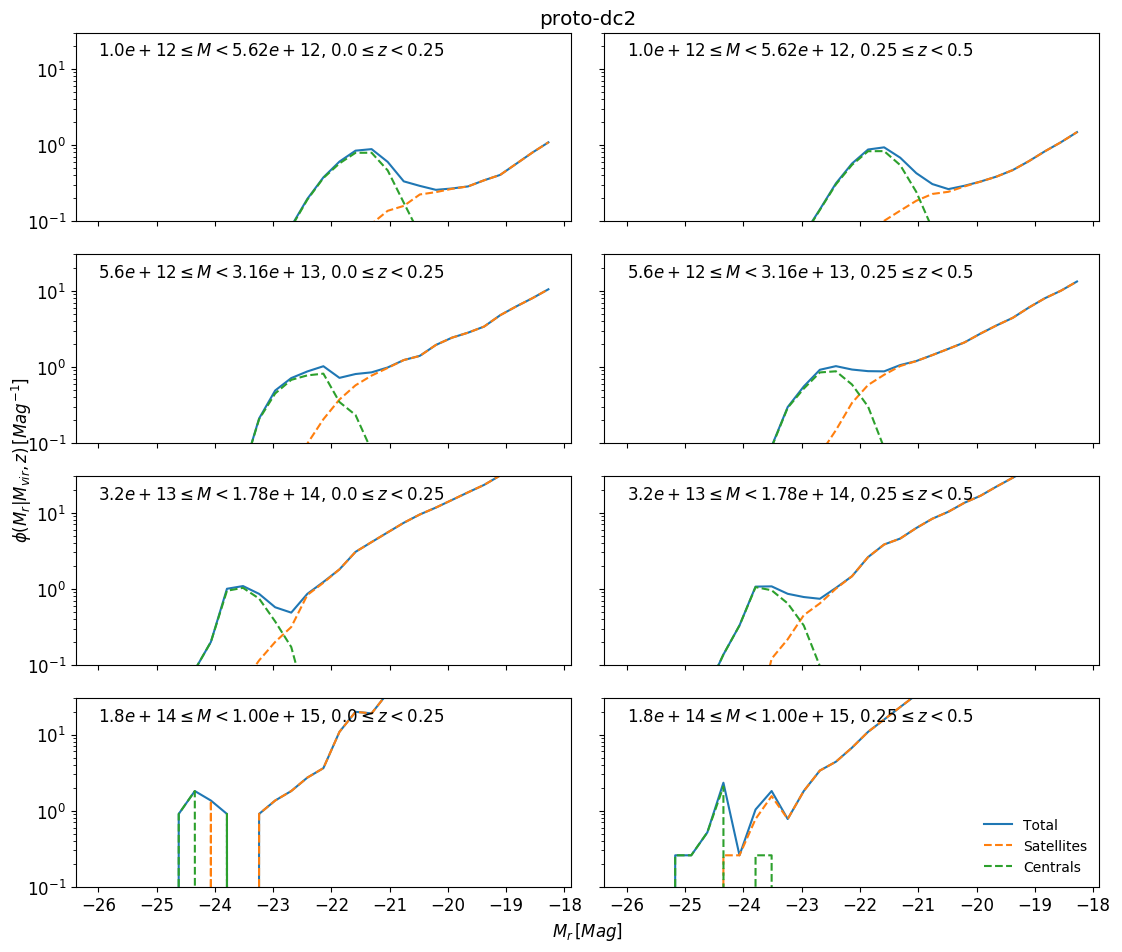

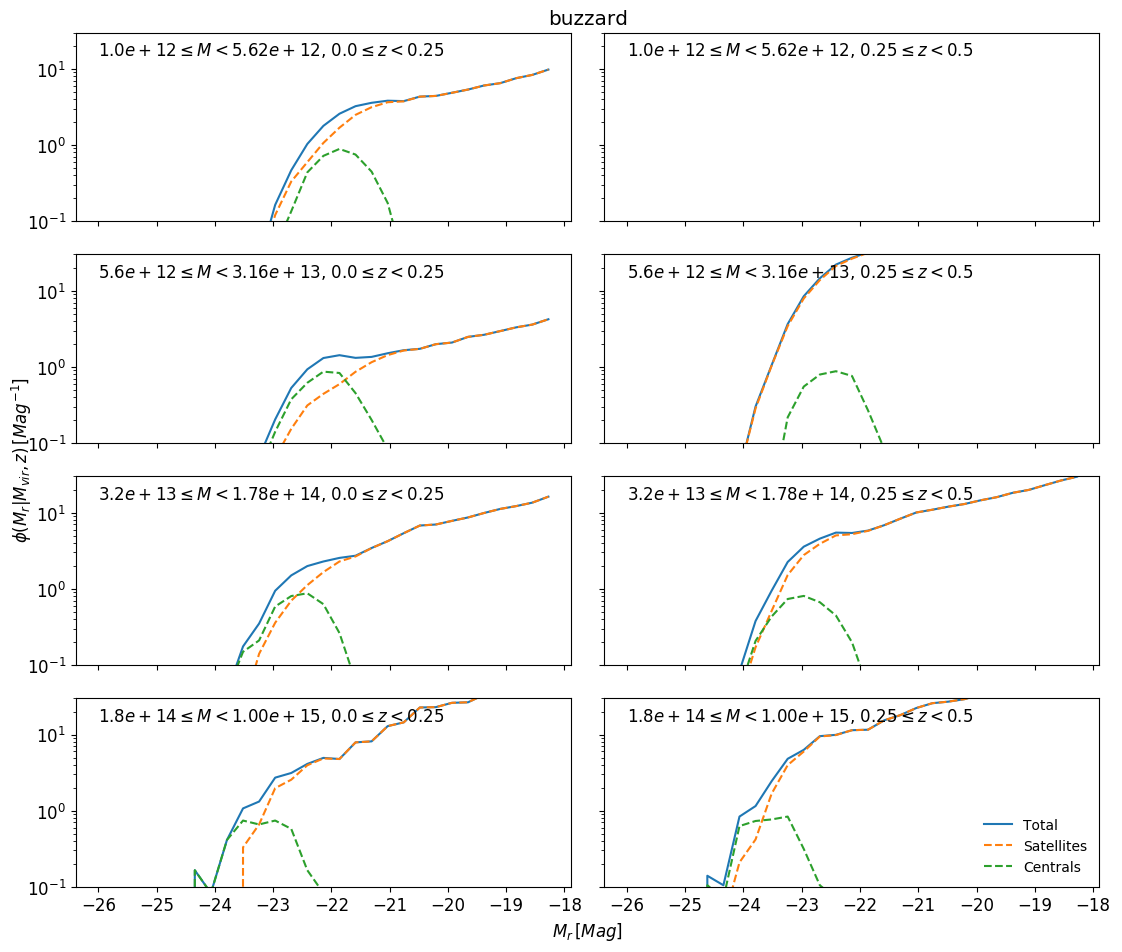

In [50]:
for label, clf_this in clf.items():    
    fig, ax = plt.subplots(clf_this.n_mass_bins, clf_this.n_z_bins, sharex=True, sharey=True, figsize=(12,10), dpi=100)

    for i in range(clf_this.n_z_bins):
        for j in range(clf_this.n_mass_bins):
            ax[j,i].plot(clf_this.magnitude_bins[:-1], clf_this.tot_clf[:,j,i], label='Total')
            ax[j,i].plot(clf_this.magnitude_bins[:-1], clf_this.sat_clf[:,j,i], label='Satellites', linestyle='--')
            ax[j,i].plot(clf_this.magnitude_bins[:-1], clf_this.cen_clf[:,j,i], label='Centrals', linestyle='--')
            ax[j,i].set_yscale('log')
            ax[j,i].set_ylim(0.1, 30)
            ax[j,i].text(-26,15, r'${:06.1e}\leq M <{:06.2e}$, ${}\leq z<{}$'.format(clf_this.mass_bins[j], 
                                                                                     clf_this.mass_bins[j+1],
                                                                                     clf_this.z_bins[i], 
                                                                                     clf_this.z_bins[i+1]))

    ax[j,i].legend(loc='lower right', frameon=False, fontsize='small')
    
    ax = fig.add_subplot(111, frameon=False)
    ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    ax.grid(False)
    ax.set_ylabel(r'$\phi(M_{r}|M_{vir},z)\/[Mag^{-1}]$')
    ax.set_xlabel(r'$M_{r}\/[Mag]$')
    ax.set_title(label)
    
    fig.tight_layout()
    display(fig)
    plt.close(fig)